In [1]:
#imports

import pandas as pd
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import numpy as np
import gensim
import gensim.downloader as api
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
model = model = gensim.models.KeyedVectors.load_word2vec_format('../../data/w2v/6/model.txt', binary=False)
print(model.most_similar(positive=["king", "woman"], negative=["man"]))



[('queen', 0.7168769240379333), ('monarch', 0.6803387403488159), ('princess', 0.6657402515411377), ('kings', 0.6593936085700989), ('regnant', 0.6519632935523987), ('monarchs', 0.6379128098487854), ('consort', 0.6045569777488708), ('prince', 0.6032231450080872), ('throne', 0.5884857773780823), ('royal', 0.5883517861366272)]


In [3]:
# Load data
data = pd.read_csv('../../data/MovieSummaries/plot_summaries_cleaned.csv')
print(data.head())

meta_data = pd.read_csv('../../data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
meta_data.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
print(meta_data.head())

   Movie ID                                       Plot summary
0  23890098  Shlykov hardworking taxi driver Lyosha saxopho...
1  31186339  nation Panem consists wealthy Capitol twelve p...
2  20663735  Poovalli Induchoodan sentenced six years priso...
3   2231378  Lemon Drop Kid New York City swindler illegall...
4    595909  Seventhday Adventist Church pastor Michael Cha...
   movie_id           1                                         movie_name  \
0    975900   /m/03vyhn                                     Ghosts of Mars   
1   3196793   /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
2  28463795  /m/0crgdbh                                        Brun bitter   
3   9363483  /m/0285_cd                                   White Of The Eye   
4    261236   /m/01mrr1                                  A Woman in Flames   

            3           4      5                                   6  \
0  2001-08-24  14010832.0   98.0  {"/m/02h40lc": "English Language"}   
1  2000-0

In [4]:
words2vec = set()

words_not_in_model = set()
# Check if all the words in the descriptions are in the model
for description in data["Plot summary"]:
    for word in description.split():
        if word in model:
            words2vec.add(word)
        else :
            # If the word is not in the model, we will try to change the first letter 
                word = word.capitalize()
                if word in model:
                    words2vec.add(word)
                else:
                    words_not_in_model.add(word)
print("Number of words in the model: ", len(words2vec))
print("Number of words not in the model: ", len(words_not_in_model))
print("Words not in the model: ", words_not_in_model)

print("lengh of a word2vec vector: ", len(model["king"]))

# Average vector for the words not in the model
average_vector = np.mean([model[word] for word in words2vec], axis=0)


Number of words in the model:  103336
Number of words not in the model:  112603
Words not in the model:  {'Worldref', 'Buddwings', 'Brydes', 'Cleaninggirl', 'Penters', 'Eveteaser', 'Maltreats', 'Josephat', 'Nonmisery', 'Thomassons', 'Cagey', 'Lamasan', '79–129', 'Ghostsdont', 'Grimmauld', 'Rivens', 'Dignified', 'Dno', 'Prameswari', 'Aidsnews', 'Narottam', 'Farewells', 'Lathika', 'Spatters', 'Pickett’s', 'Twobears', 'Nauth', 'Gownpart', 'Williams—on', 'Wangjun', 'Learys', 'Hollybank', 'Bottomofthebarrel', 'Deweys', 'Julianne’s', 'Pulat', 'Galiyan', 'Rackhams', 'Unknowningly', 'Dishonours', 'Iceal', 'Selfimpressions', 'Bearhugsue', 'Kalong', 'Böckl', 'Ludicrus', 'Dorass', 'Mahenders', 'Wonkavator', 'Maltreat', 'Amminikutty', 'Cakecooling', '‘aam', 'Happenedcite', 'Dazhao', 'Chiefmate', 'Ingratiation', 'Lionize', 'Teodoros', 'Idli’s', 'Zubins', 'Rayfords', 'Smellmaster', 'Fastforwards', 'Necessiter', 'Lokar', 'Incripted', 'Consnbspndash', 'Survieved', 'Explodesclarify', 'Yesyes', 'Sleighi

In [5]:
# Filter out the words that are not in the model


def filter_words_not_in_model_helper(word): # We explain a bit later why me choose to filter out words not in the model
    if word in model:
        return word
    elif word.lower() in model:
        return word.lower()
    elif word.capitalize() in model:
        return word.capitalize()
    else:
        return ""
def filter_words_not_in_model(s):
    return " ".join([filter_words_not_in_model_helper(word) for word in s.split()])

def filter_basic_patterns(s):
    pattern = "|".join([
    "\\d+", # Matches digits.
    r'http?://\S+|www\.\S+', # Matches url links
    ",", "\.", ":", "\(", "\)","_", "\{", "\}", "\?", "!", "&", "/", "\[", "\]", "\|", "#", "%", "\"", "\'", ";", "-", '®', 'à', '>', '<', '=', 'ü', "\*"
    ])
     # Cast uppercase letters that are not at the beginning of the string to lowercase + add a space before them
    s = re.sub(r"(?<!^)[A-Z]", lambda x: " " + x.group(0).lower(), s)
    # Cast uppercase letters that are after a point and a space to lowercase, as they are starting a new sentence
    s = re.sub(r"\. [A-Z]", lambda x: ". " + x.group(0).lower(), s)

    s = re.sub(pattern, " ", s) # replace by spaces to avoid a:b or a,b becoming ab instead of a b. 
    return s

def preprocess(s):
        s = filter_basic_patterns(s)
        s = filter_words_not_in_model(s)
        s = re.sub(r"\s+", " ", s).strip() # removing uncessary spaces
    
        return s

data["Plot summary"] = data["Plot summary"].apply(preprocess)

# Check if all the words in the descriptions are in the model
words2vec = set()
words_not_in_model = set()
for description in data["Plot summary"]:
    for word in description.split():
        if word in model:
            words2vec.add(word)
        else :
            words_not_in_model.add(word)
print("Number of words in the model: ", len(words2vec))
print("Number of words not in the model: ", len(words_not_in_model))

# find occurences of "_" 
for word in words2vec:
    if "_" in word:
        print(word)




Number of words in the model:  87637
Number of words not in the model:  0


In [6]:
# Save the data
data.to_csv("../../data/MovieSummaries/plot_summaries_cleaned_fit_model.csv", index=False)

In [7]:
# Clustering words

X = np.array([model[word] for word in words2vec])

# Now, we will cluster the words into 10 clusters
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

# Print the 10 words closest from each cluster center
for i in range(10):
    print("Cluster", i+1)
    print([model.similar_by_vector(kmeans.cluster_centers_[i])[j][0] for j in range(10)])

Cluster 1
['unjust', 'factious', 'justness', 'taqiyya', 'un-Christian', 'tyrannicide', 'unlawfulness', 'papists', 'denounce', 'tyrannies']
Cluster 2
['Nemoto', 'Kyohei', 'Takaharu', 'Ryōta', '山口', 'Yūya', 'Tōyama', 'Chinatsu', 'Ichinose', 'Ryōsuke']
Cluster 3
['childishness', 'cringing', 'childishly', 'foolish', 'silly', 'frightening', 'pathetic', 'childish', 'terrifies', 'cynical']
Cluster 4
['Miller', 'Bennett', 'Thompson', 'Patterson', 'Baker', 'Smith', 'Dunn', 'Moore', 'Ellis', 'Richardson']
Cluster 5
['Wisemans', 'andcoordinates', 'Malisian', 'Dyea', 'Perrysville', 'Tewantin', 'Hardangerfjorden', 'Peachland', 'A614', 'Ellisburg']
Cluster 6
['Gopal', 'Upreti', 'Srivastav', 'Mohan', 'Jairaj', 'Thakur', 'Jaywant', 'Raghuvir', 'Vijayendra', 'Amrapurkar']
Cluster 7
['Bragaglia', 'Marçal', 'Barnabé', 'Zanini', 'Colomer', 'Chavarría', 'Luengo', 'Armengol', 'Dávalos', 'Merello']
Cluster 8
['grater', 'unfeathered', 'midribs', 'yellowish-grey', 'cottongrass', 'tubercules', 'azuki', 'vinaigr

In [8]:
# First, compute the TF-IDF matrix of the preprocessed descriptions

vectorizer = CountVectorizer(lowercase=False, tokenizer=lambda x: x.split())

# Count number of occurence of every word for each document
vectorized = vectorizer.fit_transform(data['Plot summary'])
word_counts = pd.DataFrame(vectorized.toarray(), columns=vectorizer.get_feature_names_out(), index=data['Movie ID'])

# Compute the tf and the idf
tf = word_counts.apply(lambda r: r / r.max(), axis=1).T
idf = tf.apply(lambda r: -np.log2(r[r[r.index] != 0].count()/len(tf.columns)), axis=1)

# final term-document matrix
tf_idf = (tf.T * idf).T

X = csr_matrix(tf_idf) # Convert the dataframe to a sparse matrix to save memory

/Users/antoine/anaconda3/envs/gensim_env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
print("Shape of the TF-IDF matrix:", X.shape)

# Build maps from word to index and from movie ID to index
word_to_index = {word: i for i, word in enumerate(tf_idf.index)}
movie_id_to_index = {movie_id: i for i, movie_id in enumerate(data['Movie ID'])}

def compute_vector_movie(document, movieID):
    d_words = document.split()
  
    if len(d_words) == 0:
        return average_vector
    else:
        weighted_vec = np.array([np.mean([model[word] * X[word_to_index[word], movie_id_to_index[movieID]] for word in d_words], axis=0)])
        return weighted_vec.flatten()

Shape of the TF-IDF matrix: (87637, 42303)


In [10]:
# Compute the vector for each movie description 

vectors = np.array([compute_vector_movie(document, movieID) for document, movieID in zip(data['Plot summary'], data['Movie ID'])])

print("Shape of the vectors matrix:", vectors.shape)


Shape of the vectors matrix: (42303, 300)


Cluster 1
5 most common genres: ['Romance Film', 'Drama', 'Comedy', 'Romantic comedy', 'Indie']


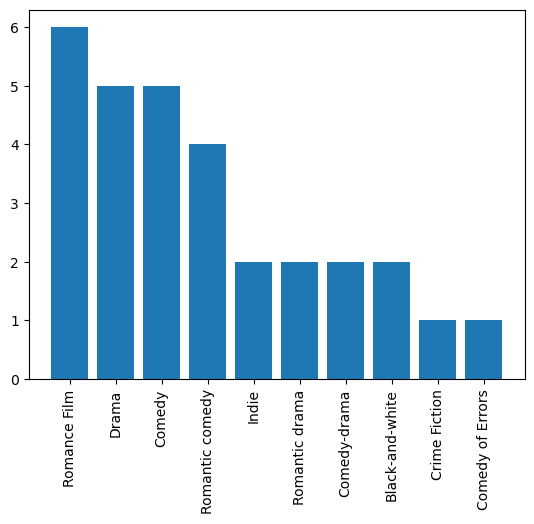

['Ask the Dust' 'Descendant' 'Just a Girl' 'Something Wild' 'Just Write'
 'Go West, Young Man' 'Lydia' 'The World of Henry Orient'
 "A Midwinter's Tale" 'Moonlight and Valentino']
Cluster 2
5 most common genres: ['Comedy', 'Drama', 'Comedy-drama', 'Indie', 'Horror']


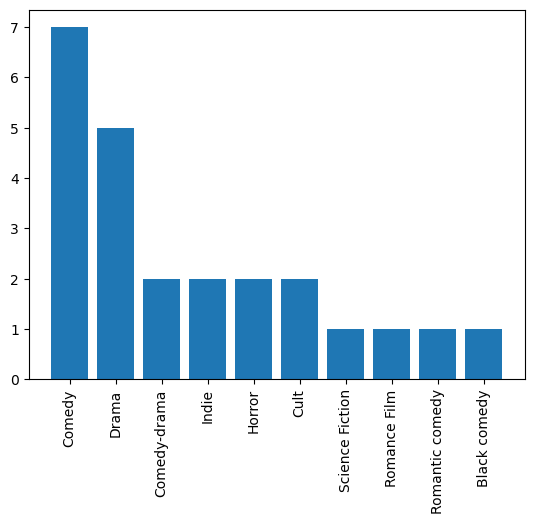

['Carry On Regardless' 'Creepshow' 'Love Actually' 'Creepshow 3'
 'Suburbia' 'Happiness' 'The Search for One-eye Jimmy' 'Broken Flowers'
 'Adam and Paul' 'Three the Hard Way']
Cluster 3
5 most common genres: ['Drama', 'Comedy', 'Indie', 'Comedy-drama', 'Crime Fiction']


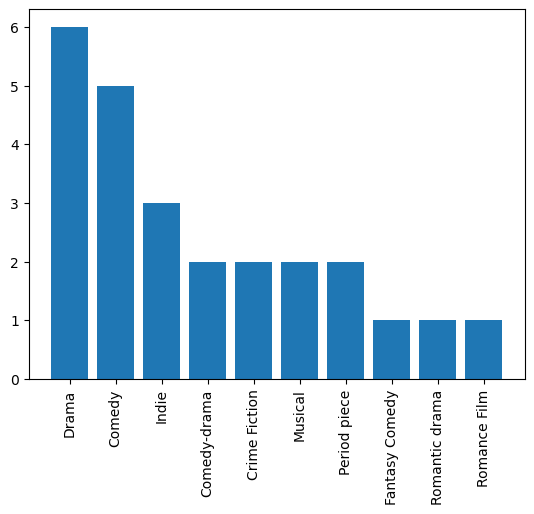

['Bright Young Things' 'Fire with Fire' 'Burning Palms' 'Twists of Terror'
 'Wedding Belles' 'SubUrbia' 'De-Lovely' 'The Secret Life of Walter Mitty'
 'Portrait of Alison' 'Moby Presents: Alien Sex Party']
Cluster 4
5 most common genres: ['Drama', 'Romance Film', 'Action', 'Crime Fiction', 'World cinema']


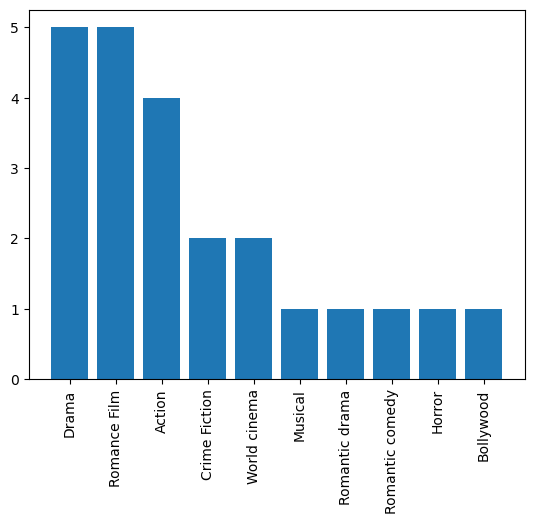

['Romeo' 'Purana mandir' 'Relax' 'Sasural' 'Ratha Kanneer' 'Meravanige'
 'Surakshaa' 'Jayamkondaan' 'Vaanam' 'Lal Patthar']
Cluster 5
5 most common genres: ['Drama', 'Romance Film', 'Comedy', 'Thriller', 'Romantic drama']


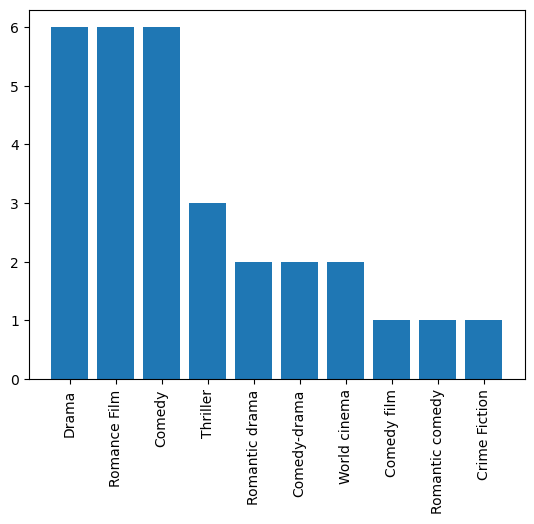

['Tales From The Dead' 'Heroes' 'The Book of Revelation' 'Manassinakkare'
 'Forever, Darling' 'In Search Of' 'Lunatics: A Love Story'
 'Happy Ero Christmas' 'Moonlight and Valentino' '44 Inch Chest']
Cluster 6
5 most common genres: ['Action', 'Drama', 'Crime Fiction', 'Family Film', 'Comedy film']


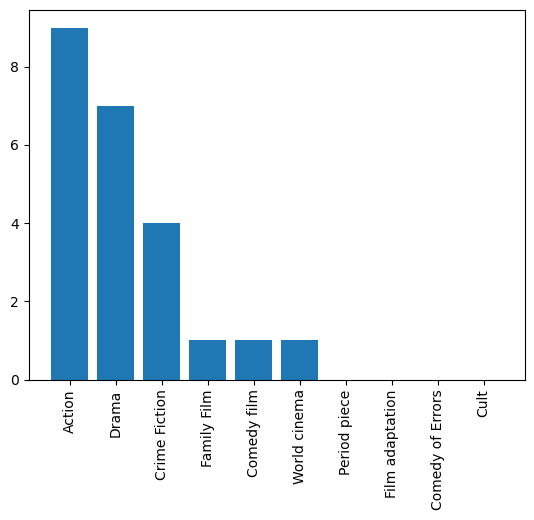

['Rakta Bandhan' 'Bees Saal Baad' 'Mar Mitenge' 'Sahhas' 'Dana Paani'
 'Hirasat' 'Galiyon Ka Badshah' 'Charno Ki Saugandh' 'Taqdeer Ka Badshah'
 'Garibon Ka Daata']
Cluster 7
5 most common genres: ['Comedy', 'Drama', 'Romance Film', 'Romantic drama', 'Ensemble Film']


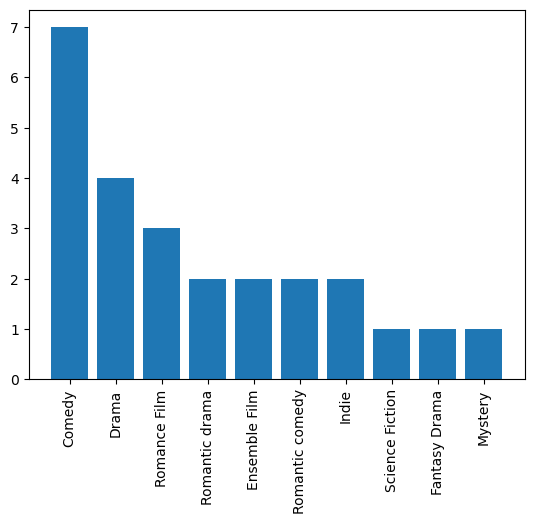

['Scenes of a Sexual Nature' "Valentine's Day" 'The Nines'
 'The First Turn-On!' 'The Facts of Life Reunion'
 'A Night in the Life of Jimmy Reardon' 'Carry On Abroad' 'Duplex'
 'One Night the Moon' 'Short Cuts']
Cluster 8
5 most common genres: ['Horror', 'Drama', 'Comedy', 'World cinema', 'Romance Film']


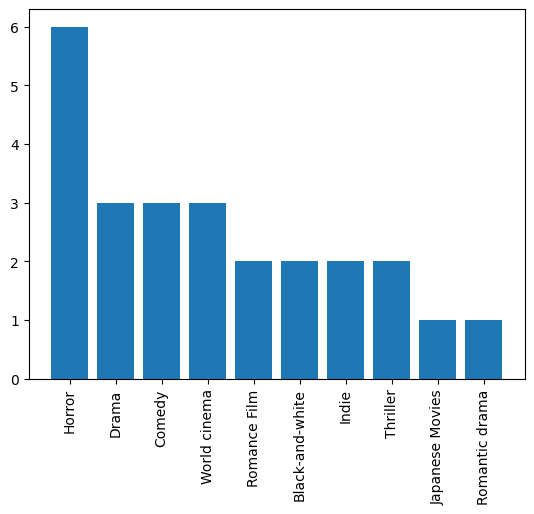

['Tales from the Crypt' 'Tokyo Eyes' 'Spellbound'
 'Shake, Rattle and Roll 2k5' 'Psychomania' 'Sweet Movie' 'Zibahkhana'
 'The Wild Child' 'Ro.Go.Pa.G.' 'Blood on the Highway']
Cluster 9
5 most common genres: ['Drama', 'World cinema', 'Action', 'Romance Film', 'Comedy']


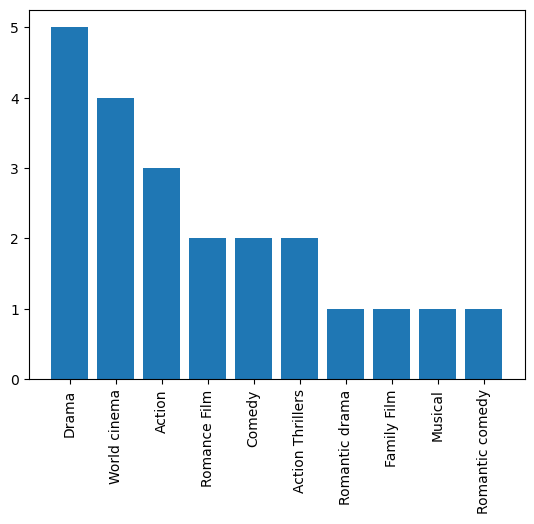

['Nammal' 'Dil Tera Aashiq' 'Aan: Men at Work' 'Samarasimha Reddy'
 'Mechanic Alludu' 'Ullasa Paravaigal' 'Jeeva' 'Khandan' 'Khoon Ka Karz'
 'Suryavamsam']
Cluster 10
5 most common genres: ['Drama', 'Comedy', 'Romantic drama', 'Romance Film', 'World cinema']


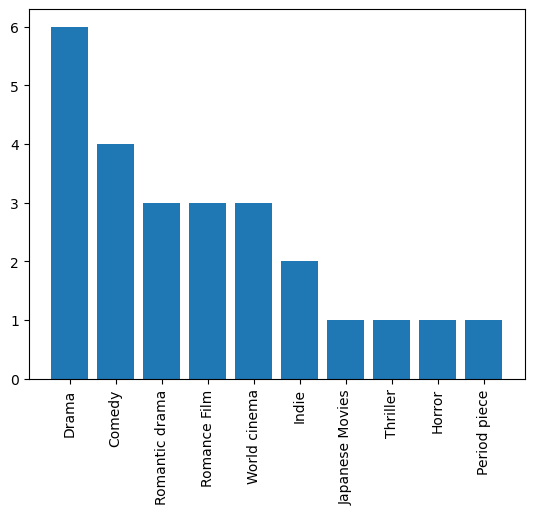

['Tales From The Dead' 'Ask the Dust' 'Choking Man' 'Heroes'
 '3 Dancing Slaves' 'A Lucky Day' 'Mapado' 'Amnèsia'
 'Lunatics: A Love Story' 'Der Lachende Mann - Bekenntnisse eines Mörders']


In [11]:
# clustering the movies
kmeans = KMeans(n_clusters=10, random_state=0).fit(vectors)

GENRES = []
# Get the 10 movies closest from each cluster center
for i in range(10):
    print("Cluster", i+1)
    genre_hist = np.zeros(len(GENRES))
    for j in range(10):
        closest_movies = data.iloc[np.argsort(np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1))[:10]]
        genre_list_string = meta_data[meta_data["movie_id"] == closest_movies["Movie ID"].values[j]]["genre"].values[0]
        # extract the genres from the genre list json
        genre_list = re.findall(r'\"(.*?)\"', genre_list_string)
        for genre in genre_list:
            # remove entries containing a / as they are not genres
            if "/" not in genre:
                if genre in GENRES:
                    genre_hist[GENRES.index(genre)] += 1
                else:
                    GENRES.append(genre)
                    genre_hist = np.append(genre_hist, 1)
    # For each cluster, print the most common genre and the % of movies in the cluster that are of this genre
    print("5 most common genres:", [GENRES[i] for i in genre_hist.argsort()[-5:][::-1]])
    top_genres = genre_hist.argsort()[-10:][::-1]

    plt.bar([GENRES[i] for i in top_genres], genre_hist[top_genres])
    plt.xticks(rotation=90)

    plt.show()
    # print movie titles from meta_data
    print(meta_data[meta_data["movie_id"].isin(closest_movies["Movie ID"].values)]["movie_name"].values)
    
    
    

    


In [12]:
# 